# Sign Language digit classification using RNN

Dataset: https://www.kaggle.com/ardamavi/sign-language-digits-dataset

Hint: Recurrent Neural Network for image classification

### Librairies 

In [114]:
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset
from os import listdir
from os.path import isfile, join
import imageio
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
# from sklearn.model_selection import train_test_split


In [115]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

### Step 1. Preprocess the data as per the given task

In [116]:
# The data are images with sign language of numbers from 0 to 9. 
# Each sign language number is in a specific folder

### Step 2. Write custom dataloader and collate function for creating train dataset and test dataset

In [117]:
# Path to the images
path_images = '/Users/prachmeanleakhena/Desktop/IDMC/sign-language-digit-classification/Dataset/'


class SignDataset(Dataset):
    """SignDataset class to read the dataset
    Inherit from torch.utils.data.Dataset
    functions: init, len, getitem and find_files"""
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.image_files = self._find_files()
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        elements = list(self.image_files.items())
#         print(elements[index][0])
        image = io.imread(elements[index][0])
        label = torch.tensor(int(elements[index][1]))
        if self.transform:
            image = self.transform(image)
        return (image, label)
    
    
    def _find_files(self):
        """Recursively finds all files matching the pattern."""
        files = {}
        for i in range(0,10):
            images = [f for f in listdir(self.root_dir+'/'+str(i)) if isfile(join(self.root_dir+'/'+str(i), f))]
            for el in images:
                files[self.root_dir+str(i)+'/'+el] = i
        return files

    
class SignCollate(object):
    """Function object used as a collate function for DataLoader."""
    def __init__(self, ):
        pass
        
    def _collate_fn(self, batch):
        new_batch = []
        for idx in range(len(batch)):
            sample = batch[idx][0]
            label = batch[idx][1]
            new_batch.append(sample)

        # scalar output
        sample_batch = np.array(new_batch)
        sample_batch = torch.FloatTensor(sample_batch)
       
        return sample_batch

    def __call__(self, batch):
        return self._collate_fn(batch)

In [118]:
dataset = SignDataset(root_dir=path_images, transform=transforms.ToTensor())  # access to the dataset
print(len(dataset))  # 2062 images

collate_fn = SignCollate()

batch_size = 32

# Split into TRAIN and TEST
train_size = int(0.9 * len(dataset))  # 90% of the data for train set
test_size = len(dataset) - train_size  # 10 % of the data for test set
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])


train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False)

# for i, (x,y) in enumerate(train_dataset):
#     print(x)

2059


### Step 3. Define the neural network model in pytorch

In [119]:
# Neural Network model -> Recurrent Neural Network (RNN)
class RNN_LSTM_classifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(RNN_LSTM_classifier, self).__init__()
        self.rnn = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
        )
        self.out = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        r_out, (_, _) = self.rnn(x, None)
        out = self.out(r_out[:, -1, :])
        return out
    
#         super(RNN_LSTM_classifier, self).__init__()
#         self.hidden_size = hidden_size
#         self.num_layers = num_layers
#         self.num_direction = num_direction
        
#         if self.num_direction == 1:
#             self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=False)
#         else:
#             self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        
#         self.fc = nn.Linear(hidden_size*self.num_direction, num_classes)
        
#     def forward(self, x):
#         # batch_size x seq_len x input_size
#         # Forward propagate LSTM
#         out, _ = self.lstm(x)  # out: tensor of shape (batch_size, seq_length, hidden_size)
        
#         # Decode the hidden state of the last time step
#         out = self.fc(out[:, -1, :])
#         return out

### Step 4. Define hyperparameters to create instance of neural network model as well as parameters required to train neural network

In [125]:
# Hyperparameters
num_layers = 2
sequence_length = 32
input_size = 100
hidden_size = 64
num_classes = 10   # 10 classes (digits from 0 to 9)
num_epochs = 500   # for the training
learning_rate = 0.01

### Step 5. Write training loop for training the model

In [126]:
model = RNN_LSTM_classifier(input_size, hidden_size,num_classes).to(device)

In [127]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [128]:
# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
#         print(i, images.shape, labels.shape, labels)
        images = images.to(device)
        labels = labels.to(device)
        images = images.reshape(-1, 300, input_size).to(device)
#         labels = labels.to(device)
        #print(images.shape, labels.shape)
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 10 == 0: #to high to see the step... 100 number of  58
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

Epoch [1/500], Step [10/58], Loss: 2.3417
Epoch [1/500], Step [20/58], Loss: 2.2931
Epoch [1/500], Step [30/58], Loss: 2.2850
Epoch [1/500], Step [40/58], Loss: 2.1175
Epoch [1/500], Step [50/58], Loss: 2.2855
Epoch [2/500], Step [10/58], Loss: 2.0901
Epoch [2/500], Step [20/58], Loss: 2.2693
Epoch [2/500], Step [30/58], Loss: 2.3215
Epoch [2/500], Step [40/58], Loss: 2.2540
Epoch [2/500], Step [50/58], Loss: 2.2539
Epoch [3/500], Step [10/58], Loss: 2.0263
Epoch [3/500], Step [20/58], Loss: 2.2329
Epoch [3/500], Step [30/58], Loss: 2.1853
Epoch [3/500], Step [40/58], Loss: 2.1102
Epoch [3/500], Step [50/58], Loss: 2.1149
Epoch [4/500], Step [10/58], Loss: 2.4935
Epoch [4/500], Step [20/58], Loss: 2.2666
Epoch [4/500], Step [30/58], Loss: 2.1955
Epoch [4/500], Step [40/58], Loss: 2.2020
Epoch [4/500], Step [50/58], Loss: 2.2186
Epoch [5/500], Step [10/58], Loss: 2.1736
Epoch [5/500], Step [20/58], Loss: 2.1380
Epoch [5/500], Step [30/58], Loss: 2.1636
Epoch [5/500], Step [40/58], Loss:

Epoch [39/500], Step [30/58], Loss: 1.8218
Epoch [39/500], Step [40/58], Loss: 1.1726
Epoch [39/500], Step [50/58], Loss: 1.8377
Epoch [40/500], Step [10/58], Loss: 1.7018
Epoch [40/500], Step [20/58], Loss: 1.6134
Epoch [40/500], Step [30/58], Loss: 1.6641
Epoch [40/500], Step [40/58], Loss: 1.7044
Epoch [40/500], Step [50/58], Loss: 1.6927
Epoch [41/500], Step [10/58], Loss: 1.4861
Epoch [41/500], Step [20/58], Loss: 1.7303
Epoch [41/500], Step [30/58], Loss: 1.4278
Epoch [41/500], Step [40/58], Loss: 1.9049
Epoch [41/500], Step [50/58], Loss: 1.7321
Epoch [42/500], Step [10/58], Loss: 1.5094
Epoch [42/500], Step [20/58], Loss: 1.3145
Epoch [42/500], Step [30/58], Loss: 2.0412
Epoch [42/500], Step [40/58], Loss: 1.3287
Epoch [42/500], Step [50/58], Loss: 1.2962
Epoch [43/500], Step [10/58], Loss: 1.4249
Epoch [43/500], Step [20/58], Loss: 1.4261
Epoch [43/500], Step [30/58], Loss: 1.4001
Epoch [43/500], Step [40/58], Loss: 1.4734
Epoch [43/500], Step [50/58], Loss: 1.4091
Epoch [44/5

Epoch [77/500], Step [40/58], Loss: 0.7507
Epoch [77/500], Step [50/58], Loss: 0.6523
Epoch [78/500], Step [10/58], Loss: 0.7447
Epoch [78/500], Step [20/58], Loss: 0.8212
Epoch [78/500], Step [30/58], Loss: 0.7903
Epoch [78/500], Step [40/58], Loss: 0.9064
Epoch [78/500], Step [50/58], Loss: 0.4717
Epoch [79/500], Step [10/58], Loss: 0.5339
Epoch [79/500], Step [20/58], Loss: 0.7841
Epoch [79/500], Step [30/58], Loss: 0.4738
Epoch [79/500], Step [40/58], Loss: 0.9392
Epoch [79/500], Step [50/58], Loss: 1.0740
Epoch [80/500], Step [10/58], Loss: 0.8955
Epoch [80/500], Step [20/58], Loss: 0.5894
Epoch [80/500], Step [30/58], Loss: 0.6245
Epoch [80/500], Step [40/58], Loss: 0.6677
Epoch [80/500], Step [50/58], Loss: 0.4985
Epoch [81/500], Step [10/58], Loss: 0.8052
Epoch [81/500], Step [20/58], Loss: 0.6193
Epoch [81/500], Step [30/58], Loss: 0.5815
Epoch [81/500], Step [40/58], Loss: 0.4774
Epoch [81/500], Step [50/58], Loss: 0.7790
Epoch [82/500], Step [10/58], Loss: 0.5353
Epoch [82/5

Epoch [115/500], Step [30/58], Loss: 0.3249
Epoch [115/500], Step [40/58], Loss: 0.2840
Epoch [115/500], Step [50/58], Loss: 0.4171
Epoch [116/500], Step [10/58], Loss: 0.2806
Epoch [116/500], Step [20/58], Loss: 0.1107
Epoch [116/500], Step [30/58], Loss: 0.4045
Epoch [116/500], Step [40/58], Loss: 0.2975
Epoch [116/500], Step [50/58], Loss: 0.2141
Epoch [117/500], Step [10/58], Loss: 0.2551
Epoch [117/500], Step [20/58], Loss: 0.1608
Epoch [117/500], Step [30/58], Loss: 0.3459
Epoch [117/500], Step [40/58], Loss: 0.2516
Epoch [117/500], Step [50/58], Loss: 0.1523
Epoch [118/500], Step [10/58], Loss: 0.1529
Epoch [118/500], Step [20/58], Loss: 0.3140
Epoch [118/500], Step [30/58], Loss: 0.2051
Epoch [118/500], Step [40/58], Loss: 0.3294
Epoch [118/500], Step [50/58], Loss: 0.5649
Epoch [119/500], Step [10/58], Loss: 0.3792
Epoch [119/500], Step [20/58], Loss: 0.4846
Epoch [119/500], Step [30/58], Loss: 0.2662
Epoch [119/500], Step [40/58], Loss: 0.0874
Epoch [119/500], Step [50/58], L

Epoch [152/500], Step [50/58], Loss: 0.1812
Epoch [153/500], Step [10/58], Loss: 0.0217
Epoch [153/500], Step [20/58], Loss: 0.0276
Epoch [153/500], Step [30/58], Loss: 0.1267
Epoch [153/500], Step [40/58], Loss: 0.0651
Epoch [153/500], Step [50/58], Loss: 0.1212
Epoch [154/500], Step [10/58], Loss: 0.1465
Epoch [154/500], Step [20/58], Loss: 0.1196
Epoch [154/500], Step [30/58], Loss: 0.0630
Epoch [154/500], Step [40/58], Loss: 0.1803
Epoch [154/500], Step [50/58], Loss: 0.0454
Epoch [155/500], Step [10/58], Loss: 0.2937
Epoch [155/500], Step [20/58], Loss: 0.3063
Epoch [155/500], Step [30/58], Loss: 0.1820
Epoch [155/500], Step [40/58], Loss: 0.0837
Epoch [155/500], Step [50/58], Loss: 0.2315
Epoch [156/500], Step [10/58], Loss: 0.0475
Epoch [156/500], Step [20/58], Loss: 0.1684
Epoch [156/500], Step [30/58], Loss: 0.4771
Epoch [156/500], Step [40/58], Loss: 0.2636
Epoch [156/500], Step [50/58], Loss: 0.6424
Epoch [157/500], Step [10/58], Loss: 0.0531
Epoch [157/500], Step [20/58], L

Epoch [190/500], Step [20/58], Loss: 0.0746
Epoch [190/500], Step [30/58], Loss: 0.0290
Epoch [190/500], Step [40/58], Loss: 0.0662
Epoch [190/500], Step [50/58], Loss: 0.2910
Epoch [191/500], Step [10/58], Loss: 0.1332
Epoch [191/500], Step [20/58], Loss: 0.1498
Epoch [191/500], Step [30/58], Loss: 0.1828
Epoch [191/500], Step [40/58], Loss: 0.0841
Epoch [191/500], Step [50/58], Loss: 0.0816
Epoch [192/500], Step [10/58], Loss: 0.4619
Epoch [192/500], Step [20/58], Loss: 0.0890
Epoch [192/500], Step [30/58], Loss: 0.0915
Epoch [192/500], Step [40/58], Loss: 0.0571
Epoch [192/500], Step [50/58], Loss: 0.1049
Epoch [193/500], Step [10/58], Loss: 0.2770
Epoch [193/500], Step [20/58], Loss: 0.0539
Epoch [193/500], Step [30/58], Loss: 0.0514
Epoch [193/500], Step [40/58], Loss: 0.0785
Epoch [193/500], Step [50/58], Loss: 0.1926
Epoch [194/500], Step [10/58], Loss: 0.1117
Epoch [194/500], Step [20/58], Loss: 0.0688
Epoch [194/500], Step [30/58], Loss: 0.0557
Epoch [194/500], Step [40/58], L

Epoch [227/500], Step [40/58], Loss: 0.0740
Epoch [227/500], Step [50/58], Loss: 0.0346
Epoch [228/500], Step [10/58], Loss: 0.0413
Epoch [228/500], Step [20/58], Loss: 0.0306
Epoch [228/500], Step [30/58], Loss: 0.0853
Epoch [228/500], Step [40/58], Loss: 0.0821
Epoch [228/500], Step [50/58], Loss: 0.0165
Epoch [229/500], Step [10/58], Loss: 0.0232
Epoch [229/500], Step [20/58], Loss: 0.0305
Epoch [229/500], Step [30/58], Loss: 0.0247
Epoch [229/500], Step [40/58], Loss: 0.0134
Epoch [229/500], Step [50/58], Loss: 0.2358
Epoch [230/500], Step [10/58], Loss: 0.0514
Epoch [230/500], Step [20/58], Loss: 0.0479
Epoch [230/500], Step [30/58], Loss: 0.0824
Epoch [230/500], Step [40/58], Loss: 0.0291
Epoch [230/500], Step [50/58], Loss: 0.0316
Epoch [231/500], Step [10/58], Loss: 0.0460
Epoch [231/500], Step [20/58], Loss: 0.0104
Epoch [231/500], Step [30/58], Loss: 0.0295
Epoch [231/500], Step [40/58], Loss: 0.0832
Epoch [231/500], Step [50/58], Loss: 0.0187
Epoch [232/500], Step [10/58], L

Epoch [265/500], Step [10/58], Loss: 0.1667
Epoch [265/500], Step [20/58], Loss: 0.1229
Epoch [265/500], Step [30/58], Loss: 0.1623
Epoch [265/500], Step [40/58], Loss: 0.0935
Epoch [265/500], Step [50/58], Loss: 0.0701
Epoch [266/500], Step [10/58], Loss: 0.1889
Epoch [266/500], Step [20/58], Loss: 0.2917
Epoch [266/500], Step [30/58], Loss: 0.0495
Epoch [266/500], Step [40/58], Loss: 0.1637
Epoch [266/500], Step [50/58], Loss: 0.0298
Epoch [267/500], Step [10/58], Loss: 0.0715
Epoch [267/500], Step [20/58], Loss: 0.1063
Epoch [267/500], Step [30/58], Loss: 0.2011
Epoch [267/500], Step [40/58], Loss: 0.0977
Epoch [267/500], Step [50/58], Loss: 0.0639
Epoch [268/500], Step [10/58], Loss: 0.0610
Epoch [268/500], Step [20/58], Loss: 0.0116
Epoch [268/500], Step [30/58], Loss: 0.1059
Epoch [268/500], Step [40/58], Loss: 0.0367
Epoch [268/500], Step [50/58], Loss: 0.0989
Epoch [269/500], Step [10/58], Loss: 0.0539
Epoch [269/500], Step [20/58], Loss: 0.0244
Epoch [269/500], Step [30/58], L

Epoch [302/500], Step [30/58], Loss: 1.8486
Epoch [302/500], Step [40/58], Loss: 1.8176
Epoch [302/500], Step [50/58], Loss: 1.9638
Epoch [303/500], Step [10/58], Loss: 1.6291
Epoch [303/500], Step [20/58], Loss: 1.8739
Epoch [303/500], Step [30/58], Loss: 1.9328
Epoch [303/500], Step [40/58], Loss: 2.0417
Epoch [303/500], Step [50/58], Loss: 1.8961
Epoch [304/500], Step [10/58], Loss: 1.8000
Epoch [304/500], Step [20/58], Loss: 1.9342
Epoch [304/500], Step [30/58], Loss: 1.7126
Epoch [304/500], Step [40/58], Loss: 1.7568
Epoch [304/500], Step [50/58], Loss: 1.8191
Epoch [305/500], Step [10/58], Loss: 1.8163
Epoch [305/500], Step [20/58], Loss: 1.8930
Epoch [305/500], Step [30/58], Loss: 1.8504
Epoch [305/500], Step [40/58], Loss: 1.9352
Epoch [305/500], Step [50/58], Loss: 1.6119
Epoch [306/500], Step [10/58], Loss: 1.8589
Epoch [306/500], Step [20/58], Loss: 1.8439
Epoch [306/500], Step [30/58], Loss: 1.8928
Epoch [306/500], Step [40/58], Loss: 2.0711
Epoch [306/500], Step [50/58], L

Epoch [339/500], Step [50/58], Loss: 1.7211
Epoch [340/500], Step [10/58], Loss: 1.3646
Epoch [340/500], Step [20/58], Loss: 1.7747
Epoch [340/500], Step [30/58], Loss: 1.6948
Epoch [340/500], Step [40/58], Loss: 1.6087
Epoch [340/500], Step [50/58], Loss: 1.7300
Epoch [341/500], Step [10/58], Loss: 1.5883
Epoch [341/500], Step [20/58], Loss: 1.5059
Epoch [341/500], Step [30/58], Loss: 1.5725
Epoch [341/500], Step [40/58], Loss: 1.4987
Epoch [341/500], Step [50/58], Loss: 1.3019
Epoch [342/500], Step [10/58], Loss: 1.3150
Epoch [342/500], Step [20/58], Loss: 1.8714
Epoch [342/500], Step [30/58], Loss: 1.5440
Epoch [342/500], Step [40/58], Loss: 1.4896
Epoch [342/500], Step [50/58], Loss: 1.7826
Epoch [343/500], Step [10/58], Loss: 1.3792
Epoch [343/500], Step [20/58], Loss: 1.5434
Epoch [343/500], Step [30/58], Loss: 1.6569
Epoch [343/500], Step [40/58], Loss: 1.4723
Epoch [343/500], Step [50/58], Loss: 1.7035
Epoch [344/500], Step [10/58], Loss: 1.7046
Epoch [344/500], Step [20/58], L

Epoch [377/500], Step [20/58], Loss: 1.5402
Epoch [377/500], Step [30/58], Loss: 1.4117
Epoch [377/500], Step [40/58], Loss: 1.5113
Epoch [377/500], Step [50/58], Loss: 1.4034
Epoch [378/500], Step [10/58], Loss: 1.2835
Epoch [378/500], Step [20/58], Loss: 1.6178
Epoch [378/500], Step [30/58], Loss: 1.3087
Epoch [378/500], Step [40/58], Loss: 1.2179
Epoch [378/500], Step [50/58], Loss: 1.5742
Epoch [379/500], Step [10/58], Loss: 1.4310
Epoch [379/500], Step [20/58], Loss: 1.3561
Epoch [379/500], Step [30/58], Loss: 1.6629
Epoch [379/500], Step [40/58], Loss: 1.2257
Epoch [379/500], Step [50/58], Loss: 1.2643
Epoch [380/500], Step [10/58], Loss: 1.2062
Epoch [380/500], Step [20/58], Loss: 1.3831
Epoch [380/500], Step [30/58], Loss: 1.3078
Epoch [380/500], Step [40/58], Loss: 1.3219
Epoch [380/500], Step [50/58], Loss: 1.4138
Epoch [381/500], Step [10/58], Loss: 1.1038
Epoch [381/500], Step [20/58], Loss: 1.0866
Epoch [381/500], Step [30/58], Loss: 1.1592
Epoch [381/500], Step [40/58], L

Epoch [414/500], Step [40/58], Loss: 1.9625
Epoch [414/500], Step [50/58], Loss: 2.0192
Epoch [415/500], Step [10/58], Loss: 1.7944
Epoch [415/500], Step [20/58], Loss: 2.2082
Epoch [415/500], Step [30/58], Loss: 2.2181
Epoch [415/500], Step [40/58], Loss: 1.8942
Epoch [415/500], Step [50/58], Loss: 1.6306
Epoch [416/500], Step [10/58], Loss: 2.2199
Epoch [416/500], Step [20/58], Loss: 1.7283
Epoch [416/500], Step [30/58], Loss: 1.7957
Epoch [416/500], Step [40/58], Loss: 1.6753
Epoch [416/500], Step [50/58], Loss: 1.8672
Epoch [417/500], Step [10/58], Loss: 2.1216
Epoch [417/500], Step [20/58], Loss: 2.0478
Epoch [417/500], Step [30/58], Loss: 1.6931
Epoch [417/500], Step [40/58], Loss: 1.9910
Epoch [417/500], Step [50/58], Loss: 1.6734
Epoch [418/500], Step [10/58], Loss: 1.9772
Epoch [418/500], Step [20/58], Loss: 1.8992
Epoch [418/500], Step [30/58], Loss: 1.8157
Epoch [418/500], Step [40/58], Loss: 2.0581
Epoch [418/500], Step [50/58], Loss: 1.8397
Epoch [419/500], Step [10/58], L

Epoch [452/500], Step [10/58], Loss: 1.2627
Epoch [452/500], Step [20/58], Loss: 1.2659
Epoch [452/500], Step [30/58], Loss: 1.0813
Epoch [452/500], Step [40/58], Loss: 2.0934
Epoch [452/500], Step [50/58], Loss: 1.2087
Epoch [453/500], Step [10/58], Loss: 1.6161
Epoch [453/500], Step [20/58], Loss: 1.4842
Epoch [453/500], Step [30/58], Loss: 1.3937
Epoch [453/500], Step [40/58], Loss: 1.7620
Epoch [453/500], Step [50/58], Loss: 1.6846
Epoch [454/500], Step [10/58], Loss: 1.0530
Epoch [454/500], Step [20/58], Loss: 1.1284
Epoch [454/500], Step [30/58], Loss: 1.2231
Epoch [454/500], Step [40/58], Loss: 1.4038
Epoch [454/500], Step [50/58], Loss: 1.2735
Epoch [455/500], Step [10/58], Loss: 1.5949
Epoch [455/500], Step [20/58], Loss: 1.1263
Epoch [455/500], Step [30/58], Loss: 1.0049
Epoch [455/500], Step [40/58], Loss: 1.1471
Epoch [455/500], Step [50/58], Loss: 1.3829
Epoch [456/500], Step [10/58], Loss: 1.3138
Epoch [456/500], Step [20/58], Loss: 1.6860
Epoch [456/500], Step [30/58], L

Epoch [489/500], Step [30/58], Loss: 0.7267
Epoch [489/500], Step [40/58], Loss: 0.9047
Epoch [489/500], Step [50/58], Loss: 1.0970
Epoch [490/500], Step [10/58], Loss: 1.0892
Epoch [490/500], Step [20/58], Loss: 0.8585
Epoch [490/500], Step [30/58], Loss: 1.0324
Epoch [490/500], Step [40/58], Loss: 1.2001
Epoch [490/500], Step [50/58], Loss: 0.9171
Epoch [491/500], Step [10/58], Loss: 0.9132
Epoch [491/500], Step [20/58], Loss: 0.7239
Epoch [491/500], Step [30/58], Loss: 1.0469
Epoch [491/500], Step [40/58], Loss: 0.6968
Epoch [491/500], Step [50/58], Loss: 1.0072
Epoch [492/500], Step [10/58], Loss: 1.0538
Epoch [492/500], Step [20/58], Loss: 0.9694
Epoch [492/500], Step [30/58], Loss: 0.9108
Epoch [492/500], Step [40/58], Loss: 1.6160
Epoch [492/500], Step [50/58], Loss: 1.0361
Epoch [493/500], Step [10/58], Loss: 1.0818
Epoch [493/500], Step [20/58], Loss: 0.8468
Epoch [493/500], Step [30/58], Loss: 0.9523
Epoch [493/500], Step [40/58], Loss: 1.1072
Epoch [493/500], Step [50/58], L

### Step 6. Evaluate the model on test data. In this part, it is expected to choose appropriate evaluation metrics based on your task. For an instance, for classification task, accuracy, precision and recall should be computed

In [129]:
#test the model

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 300, input_size).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Test Accuracy of the model on the 10000 test images: {} %'.format(round((100 * correct / total), 2))) 
    print('Precision: {} %'.format(round(torch.tensor(precision_score(labels,predicted, average='weighted')).item()*100, 2)))
    print('Recall: {} %'.format(round(torch.tensor(recall_score(labels,predicted, average='weighted')).item()*100, 2)))
    

 

# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')

Test Accuracy of the model on the 10000 test images: 65.05 %


NameError: name 'precision_score' is not defined

torch.Size([32, 3, 100, 100])


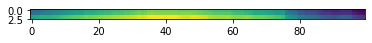

torch.Size([300, 32, 100])
Predicted label:  tensor(6)
Correct label:  tensor(7)
torch.Size([32, 3, 100, 100])


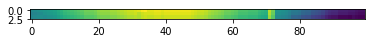

torch.Size([300, 32, 100])
Predicted label:  tensor(6)
Correct label:  tensor(5)
torch.Size([32, 3, 100, 100])


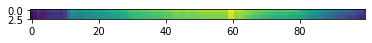

torch.Size([300, 32, 100])
Predicted label:  tensor(0)
Correct label:  tensor(6)
torch.Size([32, 3, 100, 100])


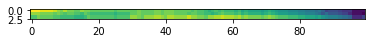

torch.Size([300, 32, 100])
Predicted label:  tensor(0)
Correct label:  tensor(5)
torch.Size([32, 3, 100, 100])


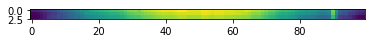

torch.Size([300, 32, 100])
Predicted label:  tensor(7)
Correct label:  tensor(0)
torch.Size([32, 3, 100, 100])


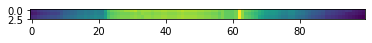

torch.Size([300, 32, 100])
Predicted label:  tensor(6)
Correct label:  tensor(5)
torch.Size([14, 3, 100, 100])


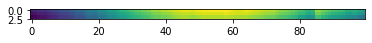

RuntimeError: shape '[-1, 32, 100]' is invalid for input of size 420000

In [130]:
for i, (images, labels) in enumerate(test_loader):
    print(images.shape)
    x_np = images.numpy()
    plt.imshow(x_np[0][:,:,1])
    plt.show()
    images = images.reshape(-1, sequence_length, input_size).to(device)
    outputs = model(images.float())
    _, predicted = torch.max(outputs.data, 1)
    print(images.shape)
    print('Predicted label: ', predicted[i])
    print('Correct label: ', labels[i])

### Step 7. Save the obtained results

In [ ]:
# with torch.no_grad():
#     correct = 0
#     total = 0
#     for images, labels in test_loader:
#         images = images.reshape(-1, 300, input_size).to(device)
#         labels = labels.to(device)
#         outputs = model(images)
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()
#     print('Test Accuracy of the model on the 10000 test images: {} %'.format(round((100 * correct / total), 2))) 
#     print('Precision: {} %'.format(round(torch.tensor(precision_score(labels,predicted, average='weighted')).item()*100, 2)))
#     print('Recall: {} %'.format(round(torch.tensor(recall_score(labels,predicted, average='weighted')).item()*100, 2)))
    

 

# # Save the model checkpoint
# torch.save(model.state_dict(), 'model.ckpt')




# # Test the model
# with torch.no_grad():
#     correct = 0
#     total = 0
#     for images, labels in test_loader:
#         images = images.reshape(-1, sequence_length, input_size).to(device)
#         labels = labels.to(device)
#         outputs = model(images)
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

#     print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total)) 

# # Save the model checkpoint
# torch.save(model.state_dict(), 'model.ckpt')